# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.02403435 -0.22837636 -0.01461711  0.31155054] 0 1.0 False {}
state, action, reward, done, info
[-0.02860188 -0.03304925 -0.0083861   0.01429389] 1 1.0 False {}
state, action, reward, done, info
[-0.02926286  0.16219196 -0.00810022 -0.28102311] 1 1.0 False {}
state, action, reward, done, info
[-0.02601902 -0.03281351 -0.01372068  0.00909407] 0 1.0 False {}
state, action, reward, done, info
[-0.02667529  0.1625025  -0.0135388  -0.28788612] 1 1.0 False {}
state, action, reward, done, info
[-0.02342524  0.35781488 -0.01929652 -0.58480813] 1 1.0 False {}
state, action, reward, done, info
[-0.01626895  0.55320174 -0.03099269 -0.88350669] 1 1.0 False {}
state, action, reward, done, info
[-0.00520491  0.74873055 -0.04866282 -1.18576944] 1 1.0 False {}
state, action, reward, done, info
[ 0.0097697   0.94444868 -0.07237821 -1.49330033] 1 1.0 False {}
state, action, reward, done, info
[ 0.02865867  1.14037273 -0.10224422 -1.80767757] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.140372725307347 -1.8076775738322648


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [22]:
def model_input(state_size):
    # States or observations as input
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [23]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [24]:
# Q function
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        return logits

In [25]:
# This is a reward function: Rt(at) or Rt(~at)
def discriminator(actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [28]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [29]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [30]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            action_size=action_size, actions=self.actions, states=self.states, hidden_size=hidden_size, 
            targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [31]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [32]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [33]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [34]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [35]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Current reward required for the Q-learning/ targetQs
            feed_dict = {model.states: states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))

            # Next action required for the Q-learning/ targetQs
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 5.0 Average reward fake: 0.46316176652908325 Average reward real: 0.46692365407943726 Training d_loss: 1.3840 Training g_loss: 0.7678 Training q_loss: 0.2492 Explore P: 0.9995
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 11.0 Average reward fake: 0.47269850969314575 Average reward real: 0.5266070365905762 Training d_loss: 1.2814 Training g_loss: 0.7494 Training q_loss: 0.5005 Explore P: 0.9984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 16.0 Average reward fake: 0.4783811569213867 Average reward real: 0.5781675577163696 Training d_loss: 1.2016 Training g_loss: 0.7442 Training q_loss: 0.8946 Explore P: 0.996

-------------------------------------------------------------------------------
Episode: 23 Total reward: 24.0 Average reward fake: 0.4660290777683258 Average reward real: 0.5147523880004883 Training d_loss: 1.3249 Training g_loss: 0.8083 Training q_loss: 182.7267 Explore P: 0.9607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 26.0 Average reward fake: 0.48409804701805115 Average reward real: 0.5583525896072388 Training d_loss: 1.3770 Training g_loss: 0.7903 Training q_loss: 3016.1311 Explore P: 0.9582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 33.0 Average reward fake: 0.4966546595096588 Average reward real: 0.5166314840316772 Training d_loss: 1.3520 Training g_loss: 0.6950 Training q_loss: 4449.5337 Explor

-------------------------------------------------------------------------------
Episode: 46 Total reward: 20.0 Average reward fake: 0.48029381036758423 Average reward real: 0.4579241871833801 Training d_loss: 1.4522 Training g_loss: 0.7309 Training q_loss: 535.9827 Explore P: 0.9079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 11.0 Average reward fake: 0.4686967432498932 Average reward real: 0.5390387773513794 Training d_loss: 1.2677 Training g_loss: 0.7995 Training q_loss: 402.8103 Explore P: 0.9070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 49.0 Average reward fake: 0.42498502135276794 Average reward real: 0.6204158663749695 Training d_loss: 1.0830 Training g_loss: 0.9292 Training q_loss: 177.9026 Explore

-------------------------------------------------------------------------------
Episode: 69 Total reward: 56.0 Average reward fake: 0.4623408317565918 Average reward real: 0.5513359308242798 Training d_loss: 1.3732 Training g_loss: 0.8315 Training q_loss: 158.9865 Explore P: 0.8605
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 16.0 Average reward fake: 0.3914162516593933 Average reward real: 0.5392082929611206 Training d_loss: 1.1470 Training g_loss: 0.9610 Training q_loss: 119.7021 Explore P: 0.8591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 14.0 Average reward fake: 0.48205962777137756 Average reward real: 0.5508329272270203 Training d_loss: 1.3477 Training g_loss: 0.7656 Training q_loss: 115.2159 Explore 

-------------------------------------------------------------------------------
Episode: 93 Total reward: 10.0 Average reward fake: 0.4356813430786133 Average reward real: 0.49278131127357483 Training d_loss: 1.3236 Training g_loss: 0.8303 Training q_loss: 217.4712 Explore P: 0.8235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 24.0 Average reward fake: 0.44101667404174805 Average reward real: 0.6147371530532837 Training d_loss: 1.2026 Training g_loss: 0.8677 Training q_loss: 239.7109 Explore P: 0.8216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 9.0 Average reward fake: 0.4105308949947357 Average reward real: 0.5524076223373413 Training d_loss: 1.2265 Training g_loss: 0.9133 Training q_loss: 161.3916 Explore 

-------------------------------------------------------------------------------
Episode: 116 Total reward: 29.0 Average reward fake: 0.4349554181098938 Average reward real: 0.5852059721946716 Training d_loss: 1.1911 Training g_loss: 0.8518 Training q_loss: 109.7037 Explore P: 0.7909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 12.0 Average reward fake: 0.44712796807289124 Average reward real: 0.5333563685417175 Training d_loss: 1.3229 Training g_loss: 0.8387 Training q_loss: 129.5906 Explore P: 0.7900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 14.0 Average reward fake: 0.40292197465896606 Average reward real: 0.6662155985832214 Training d_loss: 0.9625 Training g_loss: 0.9124 Training q_loss: 197.9330 Expl

-------------------------------------------------------------------------------
Episode: 139 Total reward: 16.0 Average reward fake: 0.3904178738594055 Average reward real: 0.5934030413627625 Training d_loss: 1.0747 Training g_loss: 0.9577 Training q_loss: 98.5063 Explore P: 0.7639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 8.0 Average reward fake: 0.394247829914093 Average reward real: 0.4896877706050873 Training d_loss: 1.3542 Training g_loss: 0.9538 Training q_loss: 84.9795 Explore P: 0.7633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 15.0 Average reward fake: 0.4136200547218323 Average reward real: 0.5045720338821411 Training d_loss: 1.2682 Training g_loss: 0.8752 Training q_loss: 538.7606 Explore P:

-------------------------------------------------------------------------------
Episode: 163 Total reward: 9.0 Average reward fake: 0.5405581593513489 Average reward real: 0.5480315685272217 Training d_loss: 1.3901 Training g_loss: 0.6387 Training q_loss: 84.1391 Explore P: 0.7334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 39.0 Average reward fake: 0.4848023056983948 Average reward real: 0.5260436534881592 Training d_loss: 1.3485 Training g_loss: 0.7477 Training q_loss: 103.0465 Explore P: 0.7305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 17.0 Average reward fake: 0.49235811829566956 Average reward real: 0.5560424327850342 Training d_loss: 1.3392 Training g_loss: 0.8529 Training q_loss: 103.1379 Explore

-------------------------------------------------------------------------------
Episode: 186 Total reward: 24.0 Average reward fake: 0.3322136402130127 Average reward real: 0.5301843881607056 Training d_loss: 1.0983 Training g_loss: 1.7861 Training q_loss: 105.0541 Explore P: 0.6938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 33.0 Average reward fake: 0.4244941174983978 Average reward real: 0.46724534034729004 Training d_loss: 1.3545 Training g_loss: 1.1109 Training q_loss: 555.2114 Explore P: 0.6915
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 188 Total reward: 10.0 Average reward fake: 0.4931887686252594 Average reward real: 0.539766788482666 Training d_loss: 1.3098 Training g_loss: 0.7285 Training q_loss: 612.9139 Explor

-------------------------------------------------------------------------------
Episode: 209 Total reward: 27.0 Average reward fake: 0.46257108449935913 Average reward real: 0.5569860339164734 Training d_loss: 1.2709 Training g_loss: 1.1323 Training q_loss: 20.9979 Explore P: 0.6622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 108.0 Average reward fake: 0.45573729276657104 Average reward real: 0.5167516469955444 Training d_loss: 1.3002 Training g_loss: 1.1030 Training q_loss: 514.0807 Explore P: 0.6552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 22.0 Average reward fake: 0.5227152109146118 Average reward real: 0.5340137481689453 Training d_loss: 1.3682 Training g_loss: 0.6585 Training q_loss: 81.7138 Explo

-------------------------------------------------------------------------------
Episode: 232 Total reward: 18.0 Average reward fake: 0.4752439558506012 Average reward real: 0.5486778020858765 Training d_loss: 1.2815 Training g_loss: 0.7734 Training q_loss: 1478.3174 Explore P: 0.6079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 23.0 Average reward fake: 0.4345197081565857 Average reward real: 0.5496266484260559 Training d_loss: 1.1833 Training g_loss: 0.8868 Training q_loss: 412.2092 Explore P: 0.6066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 29.0 Average reward fake: 0.39841729402542114 Average reward real: 0.5391343235969543 Training d_loss: 1.1941 Training g_loss: 0.9713 Training q_loss: 38.5280 Explo

-------------------------------------------------------------------------------
Episode: 255 Total reward: 28.0 Average reward fake: 0.46898287534713745 Average reward real: 0.5117872953414917 Training d_loss: 1.3208 Training g_loss: 0.7854 Training q_loss: 43.5760 Explore P: 0.5597
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 39.0 Average reward fake: 0.4844304025173187 Average reward real: 0.5363268852233887 Training d_loss: 1.3118 Training g_loss: 0.7218 Training q_loss: 99.1980 Explore P: 0.5575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 31.0 Average reward fake: 0.48988181352615356 Average reward real: 0.5282715559005737 Training d_loss: 1.3448 Training g_loss: 0.7222 Training q_loss: 1767.7487 Explo

-------------------------------------------------------------------------------
Episode: 278 Total reward: 66.0 Average reward fake: 0.5059894919395447 Average reward real: 0.5396553874015808 Training d_loss: 1.3402 Training g_loss: 0.6976 Training q_loss: 70.5012 Explore P: 0.5024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 12.0 Average reward fake: 0.4910634160041809 Average reward real: 0.5387200117111206 Training d_loss: 1.3058 Training g_loss: 0.7161 Training q_loss: 45.2889 Explore P: 0.5018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 24.0 Average reward fake: 0.4598715901374817 Average reward real: 0.4617028832435608 Training d_loss: 1.4526 Training g_loss: 0.7943 Training q_loss: 279.8236 Explore 

-------------------------------------------------------------------------------
Episode: 301 Total reward: 53.0 Average reward fake: 0.4980565011501312 Average reward real: 0.5430258512496948 Training d_loss: 1.3350 Training g_loss: 0.7225 Training q_loss: 54.6006 Explore P: 0.4472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 31.0 Average reward fake: 0.399853378534317 Average reward real: 0.5263077020645142 Training d_loss: 1.2076 Training g_loss: 1.5210 Training q_loss: 61.7802 Explore P: 0.4458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 69.0 Average reward fake: 0.4608828127384186 Average reward real: 0.49252310395240784 Training d_loss: 1.3675 Training g_loss: 0.8383 Training q_loss: 147.4810 Explore 

-------------------------------------------------------------------------------
Episode: 324 Total reward: 199.0 Average reward fake: 0.5321778059005737 Average reward real: 0.5241323709487915 Training d_loss: 1.4126 Training g_loss: 0.6399 Training q_loss: 190.5360 Explore P: 0.3582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 161.0 Average reward fake: 0.44246870279312134 Average reward real: 0.520539402961731 Training d_loss: 1.2881 Training g_loss: 1.1700 Training q_loss: 161.0235 Explore P: 0.3526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 129.0 Average reward fake: 0.550122857093811 Average reward real: 0.5588785409927368 Training d_loss: 1.3824 Training g_loss: 0.5867 Training q_loss: 1716.6947 Exp

-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Average reward fake: 0.456958532333374 Average reward real: 0.480461061000824 Training d_loss: 1.3734 Training g_loss: 0.9314 Training q_loss: 401.5045 Explore P: 0.2363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 162.0 Average reward fake: 0.5341817736625671 Average reward real: 0.5342421531677246 Training d_loss: 1.4122 Training g_loss: 0.6389 Training q_loss: 622.1793 Explore P: 0.2326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Average reward fake: 0.5358332991600037 Average reward real: 0.5194464325904846 Training d_loss: 1.4497 Training g_loss: 0.6353 Training q_loss: 228.6169 Explo

-------------------------------------------------------------------------------
Episode: 371 Total reward: 10.0 Average reward fake: 0.3360198438167572 Average reward real: 0.6897705793380737 Training d_loss: 1.1851 Training g_loss: 1.1863 Training q_loss: 3562.3345 Explore P: 0.1645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 12.0 Average reward fake: 0.3387323021888733 Average reward real: 0.5911184549331665 Training d_loss: 1.0754 Training g_loss: 1.0732 Training q_loss: 3562.0610 Explore P: 0.1643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 10.0 Average reward fake: 0.3416845202445984 Average reward real: 0.6582239270210266 Training d_loss: 0.9678 Training g_loss: 1.0833 Training q_loss: 3969.3723 Exp

-------------------------------------------------------------------------------
Episode: 394 Total reward: 15.0 Average reward fake: 0.39204055070877075 Average reward real: 0.8502928018569946 Training d_loss: 0.7135 Training g_loss: 0.9827 Training q_loss: 3232.6519 Explore P: 0.1585
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 20.0 Average reward fake: 0.2722814679145813 Average reward real: 0.6209369897842407 Training d_loss: 0.9837 Training g_loss: 1.3023 Training q_loss: 4624.0493 Explore P: 0.1582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 18.0 Average reward fake: 0.34235304594039917 Average reward real: 0.7651836276054382 Training d_loss: 1.0684 Training g_loss: 1.2050 Training q_loss: 4953.1641 E

-------------------------------------------------------------------------------
Episode: 417 Total reward: 13.0 Average reward fake: 0.31078171730041504 Average reward real: 0.583725094795227 Training d_loss: 1.0761 Training g_loss: 1.1186 Training q_loss: 1743.8129 Explore P: 0.1537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 12.0 Average reward fake: 0.37038475275039673 Average reward real: 0.7438520193099976 Training d_loss: 0.8642 Training g_loss: 1.0245 Training q_loss: 2711.1707 Explore P: 0.1535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 12.0 Average reward fake: 0.29701846837997437 Average reward real: 0.36651110649108887 Training d_loss: 1.4458 Training g_loss: 1.1800 Training q_loss: 799.9667 E

-------------------------------------------------------------------------------
Episode: 440 Total reward: 29.0 Average reward fake: 0.4092824459075928 Average reward real: 0.6208959221839905 Training d_loss: 1.1900 Training g_loss: 0.9554 Training q_loss: 261579.9062 Explore P: 0.1460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 153.0 Average reward fake: 0.5025215148925781 Average reward real: 0.5127372741699219 Training d_loss: 1.3777 Training g_loss: 0.6970 Training q_loss: 316596.4375 Explore P: 0.1439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 199.0 Average reward fake: 0.4631022810935974 Average reward real: 0.5740813612937927 Training d_loss: 1.2350 Training g_loss: 0.7776 Training q_loss: 1588.36

-------------------------------------------------------------------------------
Episode: 463 Total reward: 199.0 Average reward fake: 0.4543152451515198 Average reward real: 0.5152462720870972 Training d_loss: 1.2998 Training g_loss: 1.3793 Training q_loss: 396.1719 Explore P: 0.0971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 199.0 Average reward fake: 0.4744745194911957 Average reward real: 0.5240523219108582 Training d_loss: 1.3474 Training g_loss: 0.7861 Training q_loss: 352.9375 Explore P: 0.0954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 199.0 Average reward fake: 0.5447210073471069 Average reward real: 0.533342719078064 Training d_loss: 1.4175 Training g_loss: 0.6124 Training q_loss: 110.2863 Expl

-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.379831463098526 Average reward real: 0.5138620734214783 Training d_loss: 1.2647 Training g_loss: 1.1029 Training q_loss: 334.6262 Explore P: 0.0651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 199.0 Average reward fake: 0.5020818114280701 Average reward real: 0.5786974430084229 Training d_loss: 1.3748 Training g_loss: 0.7170 Training q_loss: 287.0715 Explore P: 0.0640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 199.0 Average reward fake: 0.5373220443725586 Average reward real: 0.5591747164726257 Training d_loss: 1.3548 Training g_loss: 0.6267 Training q_loss: 88.3871 Explo

-------------------------------------------------------------------------------
Episode: 509 Total reward: 199.0 Average reward fake: 0.5138511657714844 Average reward real: 0.5822199583053589 Training d_loss: 1.3028 Training g_loss: 0.9245 Training q_loss: 73.3239 Explore P: 0.0449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 199.0 Average reward fake: 0.517335832118988 Average reward real: 0.5239824056625366 Training d_loss: 1.3766 Training g_loss: 0.6326 Training q_loss: 55.9784 Explore P: 0.0442
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199.0 Average reward fake: 0.3204232156276703 Average reward real: 0.5900624394416809 Training d_loss: 1.0273 Training g_loss: 4.9202 Training q_loss: 82.7869 Explore

-------------------------------------------------------------------------------
Episode: 532 Total reward: 199.0 Average reward fake: 0.37296050786972046 Average reward real: 0.49075937271118164 Training d_loss: 1.2133 Training g_loss: 2.5928 Training q_loss: 18.0288 Explore P: 0.0321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 199.0 Average reward fake: 0.36172598600387573 Average reward real: 0.5312832593917847 Training d_loss: 1.1407 Training g_loss: 4.4725 Training q_loss: 22.6623 Explore P: 0.0316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 199.0 Average reward fake: 0.5626415610313416 Average reward real: 0.570605456829071 Training d_loss: 1.3930 Training g_loss: 0.5831 Training q_loss: 10.8689 Expl

-------------------------------------------------------------------------------
Episode: 555 Total reward: 199.0 Average reward fake: 0.44886165857315063 Average reward real: 0.54966139793396 Training d_loss: 1.2375 Training g_loss: 3.3038 Training q_loss: 73.8957 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 199.0 Average reward fake: 0.46985411643981934 Average reward real: 0.5315144658088684 Training d_loss: 1.2856 Training g_loss: 0.8028 Training q_loss: 4.8012 Explore P: 0.0237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 199.0 Average reward fake: 0.4897000789642334 Average reward real: 0.5647120475769043 Training d_loss: 1.2819 Training g_loss: 1.8722 Training q_loss: 36.3099 Explore

-------------------------------------------------------------------------------
Episode: 578 Total reward: 199.0 Average reward fake: 0.39462199807167053 Average reward real: 0.4927074909210205 Training d_loss: 1.2377 Training g_loss: 1.2685 Training q_loss: 11.3762 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 199.0 Average reward fake: 0.4895125925540924 Average reward real: 0.6146515011787415 Training d_loss: 1.2430 Training g_loss: 4.0089 Training q_loss: 14.1374 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 199.0 Average reward fake: 0.48862743377685547 Average reward real: 0.6147387623786926 Training d_loss: 1.2430 Training g_loss: 6.2475 Training q_loss: 22.6798 Expl

-------------------------------------------------------------------------------
Episode: 601 Total reward: 152.0 Average reward fake: 0.5435158014297485 Average reward real: 0.6080142259597778 Training d_loss: 1.3346 Training g_loss: 3.5354 Training q_loss: 27.1864 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 199.0 Average reward fake: 0.47051802277565 Average reward real: 0.543566107749939 Training d_loss: 1.2893 Training g_loss: 3.8803 Training q_loss: 43.2480 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 199.0 Average reward fake: 0.5179973244667053 Average reward real: 0.5929602384567261 Training d_loss: 1.2988 Training g_loss: 0.7648 Training q_loss: 54.4234 Explore P

-------------------------------------------------------------------------------
Episode: 624 Total reward: 191.0 Average reward fake: 0.40971118211746216 Average reward real: 0.5120223760604858 Training d_loss: 1.2761 Training g_loss: 1.9380 Training q_loss: 3.6905 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 144.0 Average reward fake: 0.43379122018814087 Average reward real: 0.4890349805355072 Training d_loss: 1.3082 Training g_loss: 3.2140 Training q_loss: 13.5996 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 176.0 Average reward fake: 0.40610820055007935 Average reward real: 0.5074028968811035 Training d_loss: 1.2387 Training g_loss: 5.1254 Training q_loss: 4.0315 Explo

-------------------------------------------------------------------------------
Episode: 647 Total reward: 199.0 Average reward fake: 0.4471137523651123 Average reward real: 0.5410186052322388 Training d_loss: 1.2472 Training g_loss: 1.0601 Training q_loss: 4.5649 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 162.0 Average reward fake: 0.4574061334133148 Average reward real: 0.5060874819755554 Training d_loss: 1.3232 Training g_loss: 2.0380 Training q_loss: 5.4018 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 199.0 Average reward fake: 0.5420429110527039 Average reward real: 0.5420432090759277 Training d_loss: 1.3940 Training g_loss: 0.6084 Training q_loss: 92.8139 Explore 

-------------------------------------------------------------------------------
Episode: 670 Total reward: 199.0 Average reward fake: 0.5619763135910034 Average reward real: 0.5621674656867981 Training d_loss: 1.4015 Training g_loss: 0.5597 Training q_loss: 13.7194 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 199.0 Average reward fake: 0.4657615125179291 Average reward real: 0.5206209421157837 Training d_loss: 1.3104 Training g_loss: 5.6056 Training q_loss: 4.1031 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 146.0 Average reward fake: 0.4574868083000183 Average reward real: 0.5180898904800415 Training d_loss: 1.3147 Training g_loss: 3.6549 Training q_loss: 7.6774 Explore 

-------------------------------------------------------------------------------
Episode: 693 Total reward: 164.0 Average reward fake: 0.38929542899131775 Average reward real: 0.546552300453186 Training d_loss: 1.1558 Training g_loss: 1.6492 Training q_loss: 10.5595 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 123.0 Average reward fake: 0.2866904139518738 Average reward real: 0.5053113102912903 Training d_loss: 1.0820 Training g_loss: 11.3811 Training q_loss: 14.3197 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 112.0 Average reward fake: 0.5899955034255981 Average reward real: 0.6331626176834106 Training d_loss: 1.3854 Training g_loss: 0.5206 Training q_loss: 5.2689 Explor

-------------------------------------------------------------------------------
Episode: 716 Total reward: 178.0 Average reward fake: 0.38751038908958435 Average reward real: 0.5707921385765076 Training d_loss: 1.1134 Training g_loss: 2.6724 Training q_loss: 3.0591 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 150.0 Average reward fake: 0.5841915011405945 Average reward real: 0.6072760820388794 Training d_loss: 1.3880 Training g_loss: 0.5446 Training q_loss: 1.5205 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 718 Total reward: 179.0 Average reward fake: 0.5180383920669556 Average reward real: 0.5562049150466919 Training d_loss: 1.3354 Training g_loss: 0.6991 Training q_loss: 1.8776 Explore 

-------------------------------------------------------------------------------
Episode: 739 Total reward: 126.0 Average reward fake: 0.5182197690010071 Average reward real: 0.5872154235839844 Training d_loss: 1.3223 Training g_loss: 4.8981 Training q_loss: 3.2028 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 89.0 Average reward fake: 0.4226743280887604 Average reward real: 0.4854872226715088 Training d_loss: 1.3019 Training g_loss: 8.5219 Training q_loss: 4.7989 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 133.0 Average reward fake: 0.546395480632782 Average reward real: 0.5488541722297668 Training d_loss: 1.3993 Training g_loss: 0.5740 Training q_loss: 12.6120 Explore P:

-------------------------------------------------------------------------------
Episode: 762 Total reward: 77.0 Average reward fake: 0.5379618406295776 Average reward real: 0.5963640213012695 Training d_loss: 1.3365 Training g_loss: 0.7628 Training q_loss: 4.6761 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 86.0 Average reward fake: 0.4696640968322754 Average reward real: 0.5251655578613281 Training d_loss: 1.3108 Training g_loss: 0.6535 Training q_loss: 9.4217 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 65.0 Average reward fake: 0.5023388266563416 Average reward real: 0.5810129642486572 Training d_loss: 1.2766 Training g_loss: 0.7277 Training q_loss: 80.4603 Explore P: 

-------------------------------------------------------------------------------
Episode: 785 Total reward: 96.0 Average reward fake: 0.5483189821243286 Average reward real: 0.5988742709159851 Training d_loss: 1.3250 Training g_loss: 0.7493 Training q_loss: 34.4560 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 66.0 Average reward fake: 0.370242714881897 Average reward real: 0.5578088760375977 Training d_loss: 1.1355 Training g_loss: 4.1609 Training q_loss: 5.0370 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 56.0 Average reward fake: 0.325684517621994 Average reward real: 0.5118285417556763 Training d_loss: 1.1248 Training g_loss: 9.4365 Training q_loss: 6.5453 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 808 Total reward: 84.0 Average reward fake: 0.435262531042099 Average reward real: 0.5600593090057373 Training d_loss: 1.2077 Training g_loss: 8.7908 Training q_loss: 1200.8647 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 73.0 Average reward fake: 0.482951819896698 Average reward real: 0.4831961989402771 Training d_loss: 1.4219 Training g_loss: 0.7532 Training q_loss: 14.9390 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 810 Total reward: 65.0 Average reward fake: 0.44711384177207947 Average reward real: 0.5391135215759277 Training d_loss: 1.2522 Training g_loss: 1.6287 Training q_loss: 102.3018 Explore

-------------------------------------------------------------------------------
Episode: 831 Total reward: 66.0 Average reward fake: 0.4416786730289459 Average reward real: 0.4993084967136383 Training d_loss: 1.3366 Training g_loss: 9.2118 Training q_loss: 3.6947 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 73.0 Average reward fake: 0.41502872109413147 Average reward real: 0.5735651254653931 Training d_loss: 1.1581 Training g_loss: 9.2322 Training q_loss: 6.5529 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 77.0 Average reward fake: 0.45458030700683594 Average reward real: 0.5650750994682312 Training d_loss: 1.2474 Training g_loss: 1.9196 Training q_loss: 72.5348 Explore P

-------------------------------------------------------------------------------
Episode: 854 Total reward: 114.0 Average reward fake: 0.48430901765823364 Average reward real: 0.5515086054801941 Training d_loss: 1.3072 Training g_loss: 9.0390 Training q_loss: 7.4913 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 80.0 Average reward fake: 0.4130796492099762 Average reward real: 0.580140233039856 Training d_loss: 1.1872 Training g_loss: 9.6960 Training q_loss: 7.8934 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 113.0 Average reward fake: 0.355064332485199 Average reward real: 0.5843191146850586 Training d_loss: 1.0345 Training g_loss: 16.9979 Training q_loss: 15.0745 Explore P

-------------------------------------------------------------------------------
Episode: 877 Total reward: 96.0 Average reward fake: 0.5441542267799377 Average reward real: 0.5464567542076111 Training d_loss: 1.3900 Training g_loss: 0.5967 Training q_loss: 5.8361 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 112.0 Average reward fake: 0.5219392776489258 Average reward real: 0.5671970844268799 Training d_loss: 1.3420 Training g_loss: 0.7838 Training q_loss: 6.2263 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 879 Total reward: 95.0 Average reward fake: 0.4478720724582672 Average reward real: 0.4988837242126465 Training d_loss: 1.3152 Training g_loss: 8.6529 Training q_loss: 7.3399 Explore P: 

-------------------------------------------------------------------------------
Episode: 900 Total reward: 107.0 Average reward fake: 0.5132620334625244 Average reward real: 0.513486385345459 Training d_loss: 1.3867 Training g_loss: 0.6755 Training q_loss: 10.4314 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 147.0 Average reward fake: 0.5496380925178528 Average reward real: 0.5588343739509583 Training d_loss: 1.3811 Training g_loss: 0.6392 Training q_loss: 9.1668 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 115.0 Average reward fake: 0.4983213543891907 Average reward real: 0.5499239563941956 Training d_loss: 1.3415 Training g_loss: 2.9408 Training q_loss: 14.0062 Explore 

-------------------------------------------------------------------------------
Episode: 923 Total reward: 108.0 Average reward fake: 0.4563000798225403 Average reward real: 0.50255286693573 Training d_loss: 1.3158 Training g_loss: 0.8548 Training q_loss: 3.6064 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 125.0 Average reward fake: 0.44789552688598633 Average reward real: 0.5599542856216431 Training d_loss: 1.2382 Training g_loss: 14.3505 Training q_loss: 5.9703 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 163.0 Average reward fake: 0.5187256336212158 Average reward real: 0.5254717469215393 Training d_loss: 1.3864 Training g_loss: 0.6699 Training q_loss: 0.6730 Explore P

-------------------------------------------------------------------------------
Episode: 946 Total reward: 80.0 Average reward fake: 0.5704222917556763 Average reward real: 0.5743120908737183 Training d_loss: 1.4002 Training g_loss: 0.5633 Training q_loss: 1.5522 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 82.0 Average reward fake: 0.427905410528183 Average reward real: 0.4870758056640625 Training d_loss: 1.3017 Training g_loss: 1.1044 Training q_loss: 3.5504 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 120.0 Average reward fake: 0.5629451870918274 Average reward real: 0.6298816800117493 Training d_loss: 1.3481 Training g_loss: 8.1800 Training q_loss: 6.4350 Explore P: 0

-------------------------------------------------------------------------------
Episode: 969 Total reward: 115.0 Average reward fake: 0.42410939931869507 Average reward real: 0.5595542192459106 Training d_loss: 1.1864 Training g_loss: 2.3022 Training q_loss: 1.5726 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 98.0 Average reward fake: 0.4803096652030945 Average reward real: 0.535633385181427 Training d_loss: 1.3134 Training g_loss: 7.0754 Training q_loss: 1.2017 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 99.0 Average reward fake: 0.4714844226837158 Average reward real: 0.5234283208847046 Training d_loss: 1.3153 Training g_loss: 8.9496 Training q_loss: 4.5075 Explore P: 

-------------------------------------------------------------------------------
Episode: 992 Total reward: 82.0 Average reward fake: 0.5173167586326599 Average reward real: 0.5411421060562134 Training d_loss: 1.3757 Training g_loss: 0.5896 Training q_loss: 272.5083 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 56.0 Average reward fake: 0.36805492639541626 Average reward real: 0.5405969023704529 Training d_loss: 1.1835 Training g_loss: 1.8692 Training q_loss: 6.7264 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 96.0 Average reward fake: 0.5102070569992065 Average reward real: 0.644758403301239 Training d_loss: 1.2528 Training g_loss: 3.7870 Training q_loss: 12.5746 Explore P

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

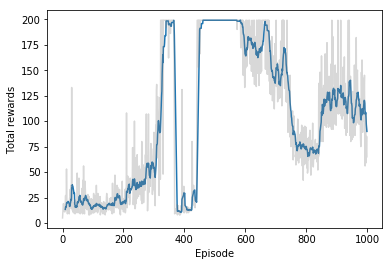

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

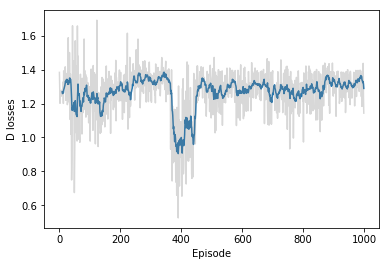

In [38]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

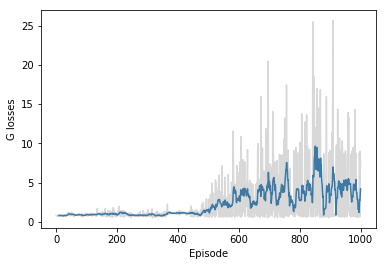

In [39]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

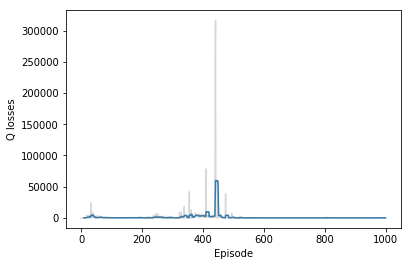

In [40]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [41]:
test_episodes = 10
test_max_steps = 1000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [26]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.